In [56]:
import pandas as pd
import json
import matplotlib.pyplot as plt
from urllib.parse import unquote
import seaborn as sns
import numpy as np
import missingno as msno
from sklearn.preprocessing import StandardScaler

In [57]:
with open("../utilities/mod_listings_4499.json") as f:
    json_listings = json.load(f)["data"]

In [58]:
listings = pd.DataFrame(json_listings)

In [59]:
listings.columns

Index(['_id', 'title', 'price', 'odometer', 'link', 'location', 'post_body',
       'year', 'makemodel', 'latitude', 'longitude', 'attributes', 'images',
       'source', 'scraper_version', 'scrape_date', 'stage', 'cleaner_version',
       'make', 'model', 'model_scores', 'model_versions', 'risk_score',
       'pending_risk_update', 'human_flag', 'seller_website'],
      dtype='object')

In [60]:
DONT_DECODE = ["link", "images"]

def decode(obj):
    decoded_obj = {}

    for field, value in obj.items():
        if isinstance(value, str) and field not in DONT_DECODE:
            decoded_obj[field] = unquote(value).strip()
        elif (
            isinstance(value, list)
            and isinstance(value[0], str)
            and field not in DONT_DECODE
        ):
            decoded_obj[field] = decode_arr(value)
        else:
            decoded_obj[field] = value

    return decoded_obj

def decode_arr(arr):
    decoded_arr = []

    for elem in arr:
        decoded_arr.append(unquote(elem).strip())

    return decoded_arr

In [61]:
listings.drop(columns=["_id", "scraper_version", "scrape_date", "stage", "cleaner_version", "pending_risk_update", "model_versions", "model_scores", "human_flag"], inplace=True)

listings['images'] = listings['images'].apply(len)

attributes_df = listings['attributes'].apply(pd.Series)
attributes_df.drop(columns=["odometer", "title"], inplace = True, axis = 1)
listings = pd.concat([listings.drop(columns=['attributes']), attributes_df], axis=1)

listings = listings.apply(lambda row: pd.Series(decode(row)), axis=1)
listings.head()

,title,price,odometer,link,location,post_body,year,makemodel,latitude,longitude,...,cylinders,drive,fuel,paint_color,title_status,transmission,type,vin,safety_rating,fuel_type
0,2011 CHEVROLET TRAVERSE LT,5499,128090,https://mcallen.craigslist.org/ctd/d/san-juan-...,Alamo,QR Code Link to This Post\n\n\n956 378 7623,2011,chevrolet traverse lt,26.164463,-98.126525,...,6 cylinders,fwd,gas,white,clean,automatic,SUV,NaN,NaN,NaN
1,2020 HONDA CIVIC LX SEDAN LOW MILES,14999,30000,https://mcallen.craigslist.org/ctd/d/alamo-202...,NaN,"QR Code Link to This Post\n\n\n🚗$14,995 CASH \...",2020,honda civic lx sedan,26.190600,-98.116400,...,NaN,NaN,gas,NaN,rebuilt,automatic,NaN,NaN,NaN,NaN
2,"CHEVROLET IMPALA 91k miles 6,500 CASH WOW",6500,91000,https://mcallen.craigslist.org/ctd/d/alamo-che...,Call (956)313-3355 FRANK JR IN ALAMO TX,"QR Code Link to This Post\n\n\n$6,500 CASH WOW...",2014,chevrolet impala ls,26.190600,-98.116400,...,NaN,NaN,gas,NaN,rebuilt,automatic,NaN,NaN,NaN,NaN
3,2018 CHRYSLER PACIFICA LOADED 3 ROW LEATHER 72...,14999,73000,https://mcallen.craigslist.org/ctd/d/alamo-201...,Call (956)313-3355 FRANK JR IN ALAMO TX,QR Code Link to This Post\n\n\nCall Frankie to...,2018,chrysler pacifica touring,26.190600,-98.116400,...,NaN,NaN,gas,NaN,clean,automatic,NaN,NaN,NaN,NaN
4,‼️NEW CAR ARRIVALS‼️,111111,111111,https://mcallen.craigslist.org/ctd/d/mcallen-n...,MCALLEN,QR Code Link to This Post\n\n\n‼️NEW ARRIVALS ...,2020,dodge ram 1500,26.215400,-98.235900,...,NaN,NaN,gas,NaN,clean,automatic,NaN,NaN,NaN,NaN


In [62]:
listings.describe().apply(lambda x: x.apply('{0:.0f}'.format))

,price,odometer,year,latitude,longitude,images,risk_score,safety_rating
count,4430,4430,4430,4079,4079,4430,4430,77
mean,20288,100561,2016,31,-98,17,29,1
std,23875,62815,4,2,4,6,19,0
min,1,1,2000,26,-123,2,1,1
25%,8995,56110,2014,30,-98,12,11,1
50%,16679,96000,2017,30,-97,19,22,1
75%,25995,136656,2019,33,-97,24,41,1
max,800950,999999,2025,46,-73,24,100,1


In [63]:
listings.isna().sum()

title                0
price                0
odometer             0
link                 0
location          1545
post_body            0
year                 0
makemodel          351
latitude           351
longitude          351
images               0
source               0
make                 0
model                0
risk_score           0
seller_website    2885
condition         2181
cylinders         1241
drive             1403
fuel               353
paint_color       2316
title_status       410
transmission       134
type              1332
vin               3002
safety_rating     4353
fuel_type         4359
dtype: int64

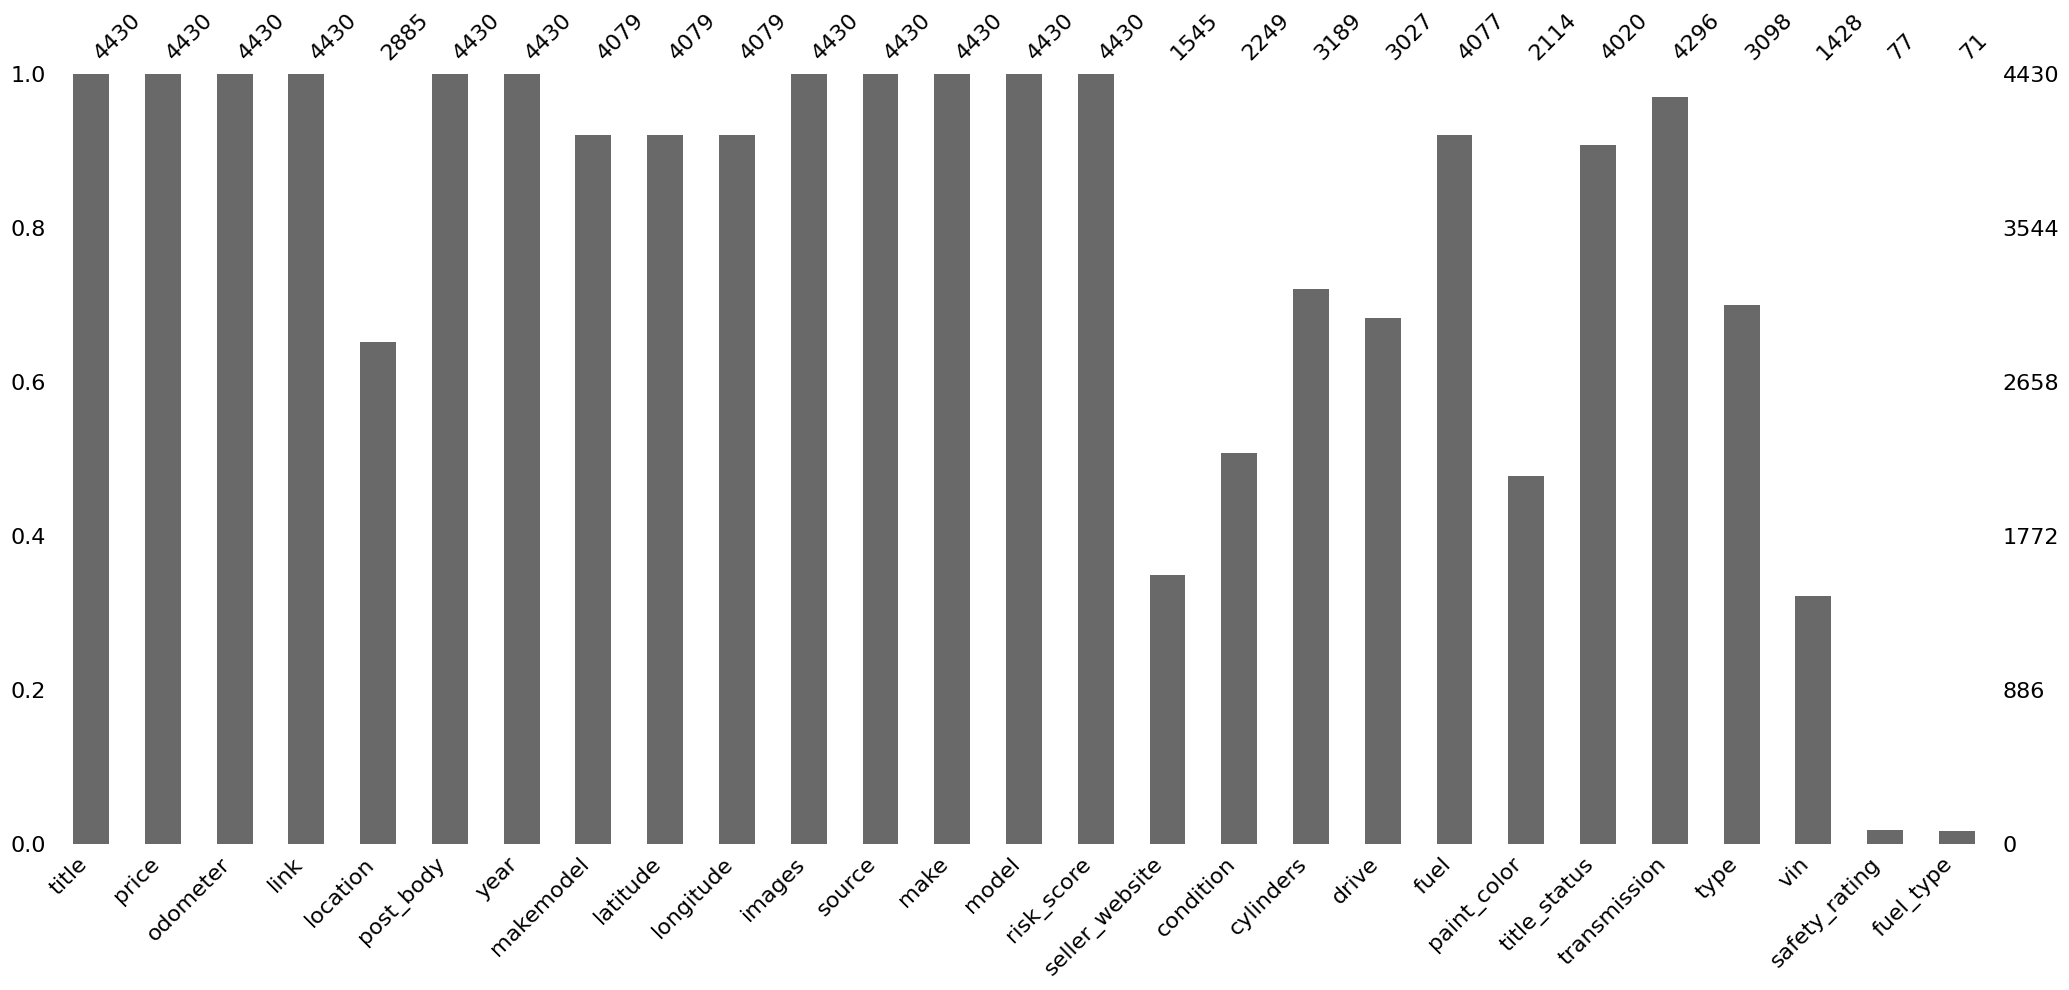

In [64]:
msno.bar(listings)
plt.show()

In [65]:
listings["condition"] = listings["condition"].fillna("empty")

listings["longitude"] = listings["longitude"].fillna(listings["longitude"].mode()[0])
listings["latitude"] = listings["latitude"].fillna(listings["latitude"].mode()[0])
listings["transmission"] = listings["transmission"].fillna(listings["transmission"].mode()[0])
listings["transmission"] = listings["transmission"].fillna(listings["transmission"].mode()[0])
listings["title_status"] = listings["title_status"].fillna(listings["title_status"].mode()[0])
listings["fuel"] = listings["fuel"].fillna(listings["fuel"].mode()[0])
listings['vin'] = listings['vin'].notna().astype(int)

listings.drop(columns=["location", "seller_website", "makemodel", "safety_rating", "paint_color", "fuel_type", "cylinders", "type", "drive"], inplace=True)

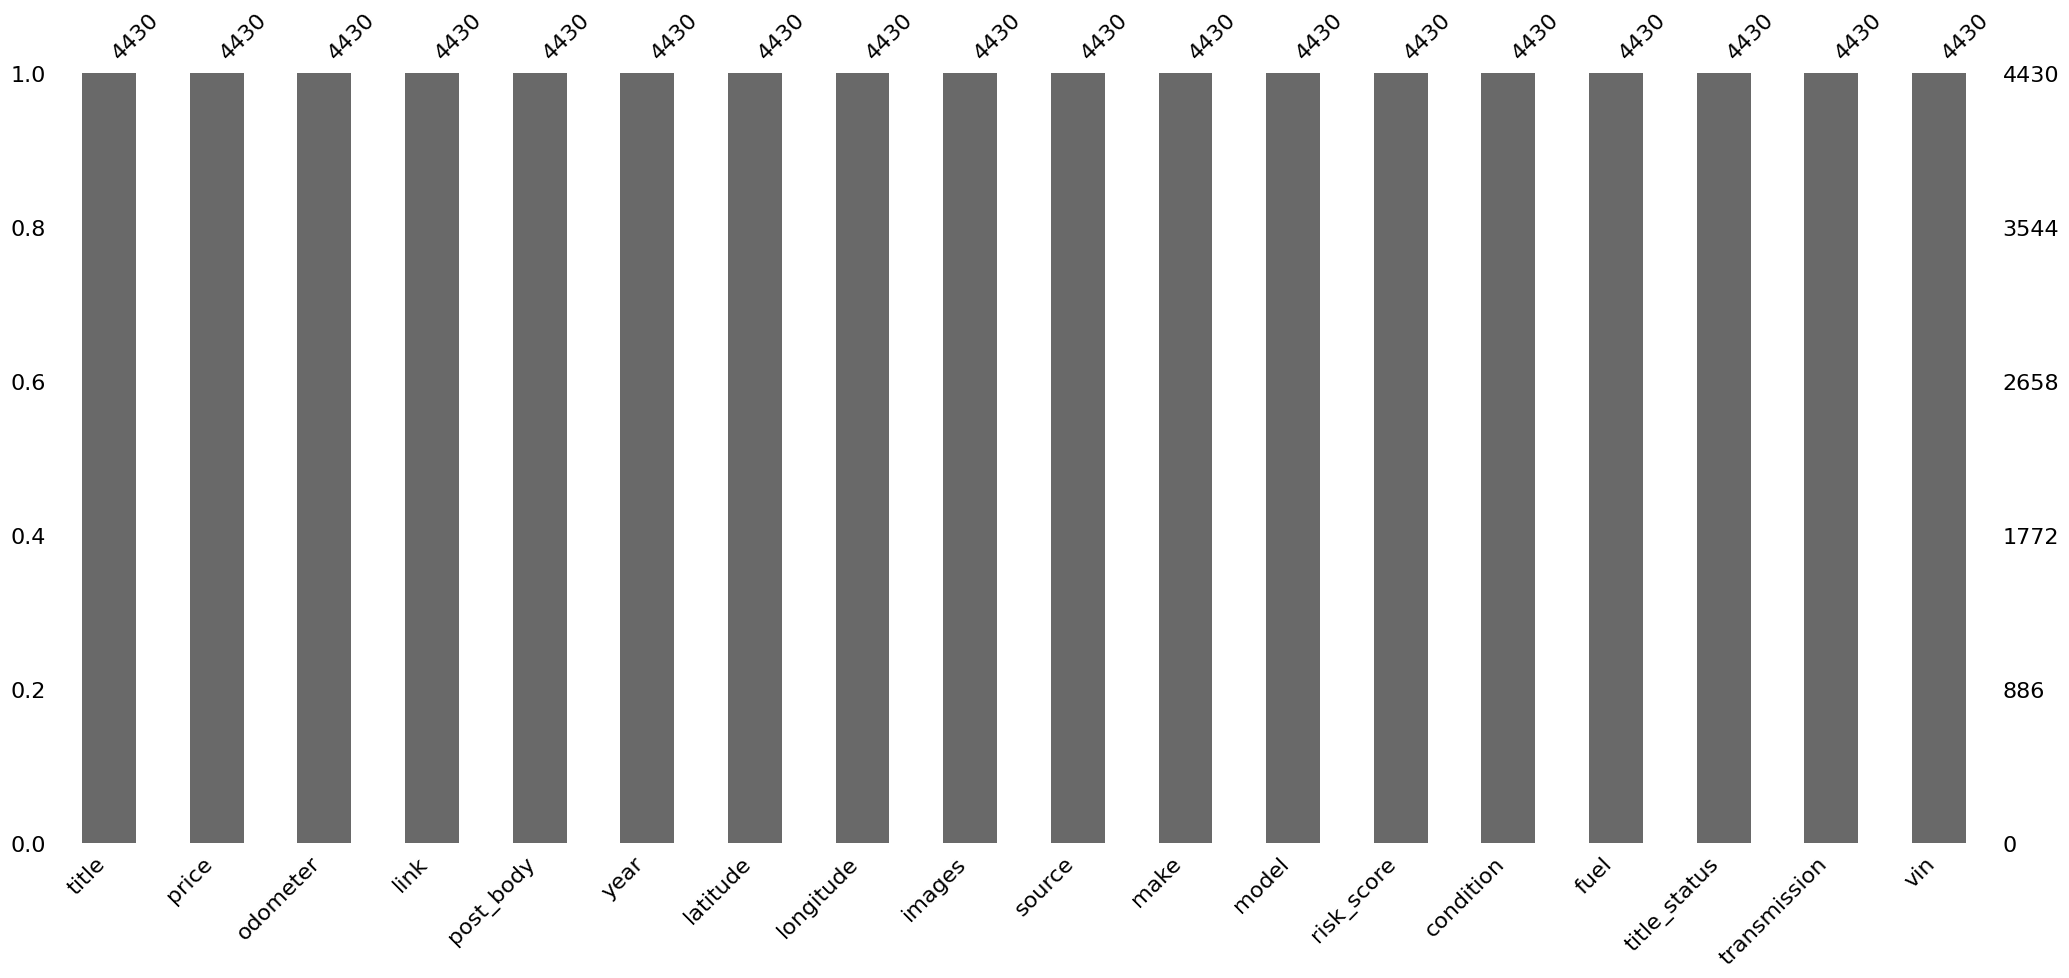

In [66]:
msno.bar(listings)
plt.show()

In [67]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4430 entries, 0 to 4429
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   title         4430 non-null   object 
 1   price         4430 non-null   int64  
 2   odometer      4430 non-null   int64  
 3   link          4430 non-null   object 
 4   post_body     4430 non-null   object 
 5   year          4430 non-null   int64  
 6   latitude      4430 non-null   float64
 7   longitude     4430 non-null   float64
 8   images        4430 non-null   int64  
 9   source        4430 non-null   object 
 10  make          4430 non-null   object 
 11  model         4430 non-null   object 
 12  risk_score    4430 non-null   float64
 13  condition     4430 non-null   object 
 14  fuel          4430 non-null   object 
 15  title_status  4430 non-null   object 
 16  transmission  4430 non-null   object 
 17  vin           4430 non-null   int64  
dtypes: float64(3), int64(5), obj

In [68]:
cat_listings = listings.select_dtypes(include = ['object'])
cat_listings.drop(columns=["title", "post_body", "link"], inplace=True, axis=1)
cat_listings.head()

,source,make,model,condition,fuel,title_status,transmission
0,craigslist,chevrolet,Traverse,excellent,gas,clean,automatic
1,craigslist,honda,Civic Type R,empty,gas,rebuilt,automatic
2,craigslist,chevrolet,Impala,empty,gas,rebuilt,automatic
3,craigslist,chrysler,Pacifica Hybrid,empty,gas,clean,automatic
4,craigslist,dodge,RAM 50,empty,gas,clean,automatic


In [69]:
for col in cat_listings.columns:
    if col not in ["make", "model"]:
        print(f"{col}: \n{cat_listings[col].unique()}\n")

source: 
['craigslist' 'facebook']

condition: 
['excellent' 'empty' 'good' 'like new' 'fair' 'new' 'in great' 'in good'
 'drive\nexcellent' 'really good' 'good\ngood' 'tires good' 'salvage']

fuel: 
['gas' 'diesel' 'electric' 'hybrid' 'other']

title_status: 
['clean' 'rebuilt' 'salvage' 'lien' 'parts only' 'missing']

transmission: 
['automatic' 'manual' 'other']



In [70]:
def clean_conditions(condition):
    condition = condition.replace("in great", "great").replace("in good", "good")
    condition = condition.replace("drive\nexcellent", "excellent").replace("tires good", "good")
    condition = condition.replace("good\ngood", "good")
    return condition

cat_listings['condition'] = cat_listings['condition'].apply(clean_conditions)

In [71]:
for col in cat_listings.columns:
    if col not in ["make", "model"]:
        print(f"{col}: \n{cat_listings[col].unique()}\n")

source: 
['craigslist' 'facebook']

condition: 
['excellent' 'empty' 'good' 'like new' 'fair' 'new' 'great' 'really good'
 'salvage']

fuel: 
['gas' 'diesel' 'electric' 'hybrid' 'other']

title_status: 
['clean' 'rebuilt' 'salvage' 'lien' 'parts only' 'missing']

transmission: 
['automatic' 'manual' 'other']



In [72]:
for column in cat_listings.columns:
    cat_listings[column] = pd.Categorical(cat_listings[column]).codes

cat_listings.head()

,source,make,model,condition,fuel,title_status,transmission
0,0,8,506,1,2,0,0
1,0,15,122,0,2,4,0
2,0,8,250,0,2,4,0
3,0,9,337,0,2,0,0
4,0,10,373,0,2,0,0


In [73]:
listings = pd.concat([listings.drop(columns=cat_listings.columns), cat_listings], axis=1)
listings.head()

,title,price,odometer,link,post_body,year,latitude,longitude,images,risk_score,vin,source,make,model,condition,fuel,title_status,transmission
0,2011 CHEVROLET TRAVERSE LT,5499,128090,https://mcallen.craigslist.org/ctd/d/san-juan-...,QR Code Link to This Post\n\n\n956 378 7623,2011,26.164463,-98.126525,17,10.670,0,0,8,506,1,2,0,0
1,2020 HONDA CIVIC LX SEDAN LOW MILES,14999,30000,https://mcallen.craigslist.org/ctd/d/alamo-202...,"QR Code Link to This Post\n\n\n🚗$14,995 CASH \...",2020,26.190600,-98.116400,17,10.000,0,0,15,122,0,2,4,0
2,"CHEVROLET IMPALA 91k miles 6,500 CASH WOW",6500,91000,https://mcallen.craigslist.org/ctd/d/alamo-che...,"QR Code Link to This Post\n\n\n$6,500 CASH WOW...",2014,26.190600,-98.116400,2,10.668,0,0,8,250,0,2,4,0
3,2018 CHRYSLER PACIFICA LOADED 3 ROW LEATHER 72...,14999,73000,https://mcallen.craigslist.org/ctd/d/alamo-201...,QR Code Link to This Post\n\n\nCall Frankie to...,2018,26.190600,-98.116400,12,10.236,0,0,9,337,0,2,0,0
4,‼️NEW CAR ARRIVALS‼️,111111,111111,https://mcallen.craigslist.org/ctd/d/mcallen-n...,QR Code Link to This Post\n\n\n‼️NEW ARRIVALS ...,2020,26.215400,-98.235900,23,20.000,0,0,10,373,0,2,0,0


In [74]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4430 entries, 0 to 4429
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   title         4430 non-null   object 
 1   price         4430 non-null   int64  
 2   odometer      4430 non-null   int64  
 3   link          4430 non-null   object 
 4   post_body     4430 non-null   object 
 5   year          4430 non-null   int64  
 6   latitude      4430 non-null   float64
 7   longitude     4430 non-null   float64
 8   images        4430 non-null   int64  
 9   risk_score    4430 non-null   float64
 10  vin           4430 non-null   int64  
 11  source        4430 non-null   int8   
 12  make          4430 non-null   int8   
 13  model         4430 non-null   int16  
 14  condition     4430 non-null   int8   
 15  fuel          4430 non-null   int8   
 16  title_status  4430 non-null   int8   
 17  transmission  4430 non-null   int8   
dtypes: float64(3), int16(1), int

In [75]:
numeric_listings = listings.select_dtypes(exclude=["object"])

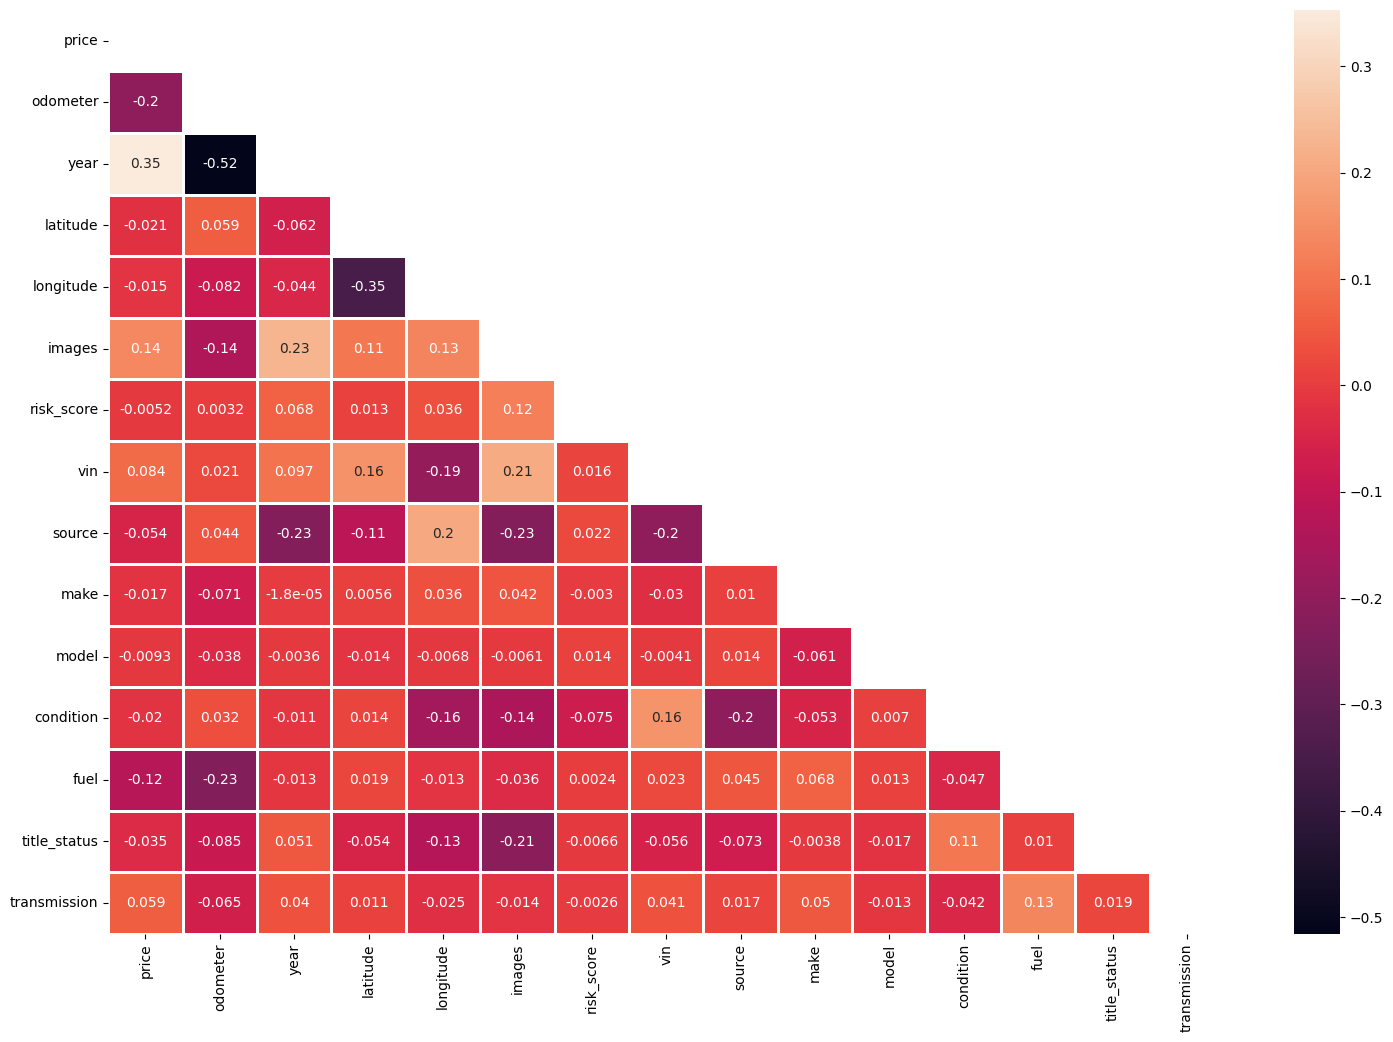

In [76]:

plt.figure(figsize = (18, 12))

corr = numeric_listings.corr()
mask = np.triu(np.ones_like(corr, dtype = bool))

sns.heatmap(data = corr, mask = mask, annot = True, fmt = '.2g', linewidth = 1)
plt.show()

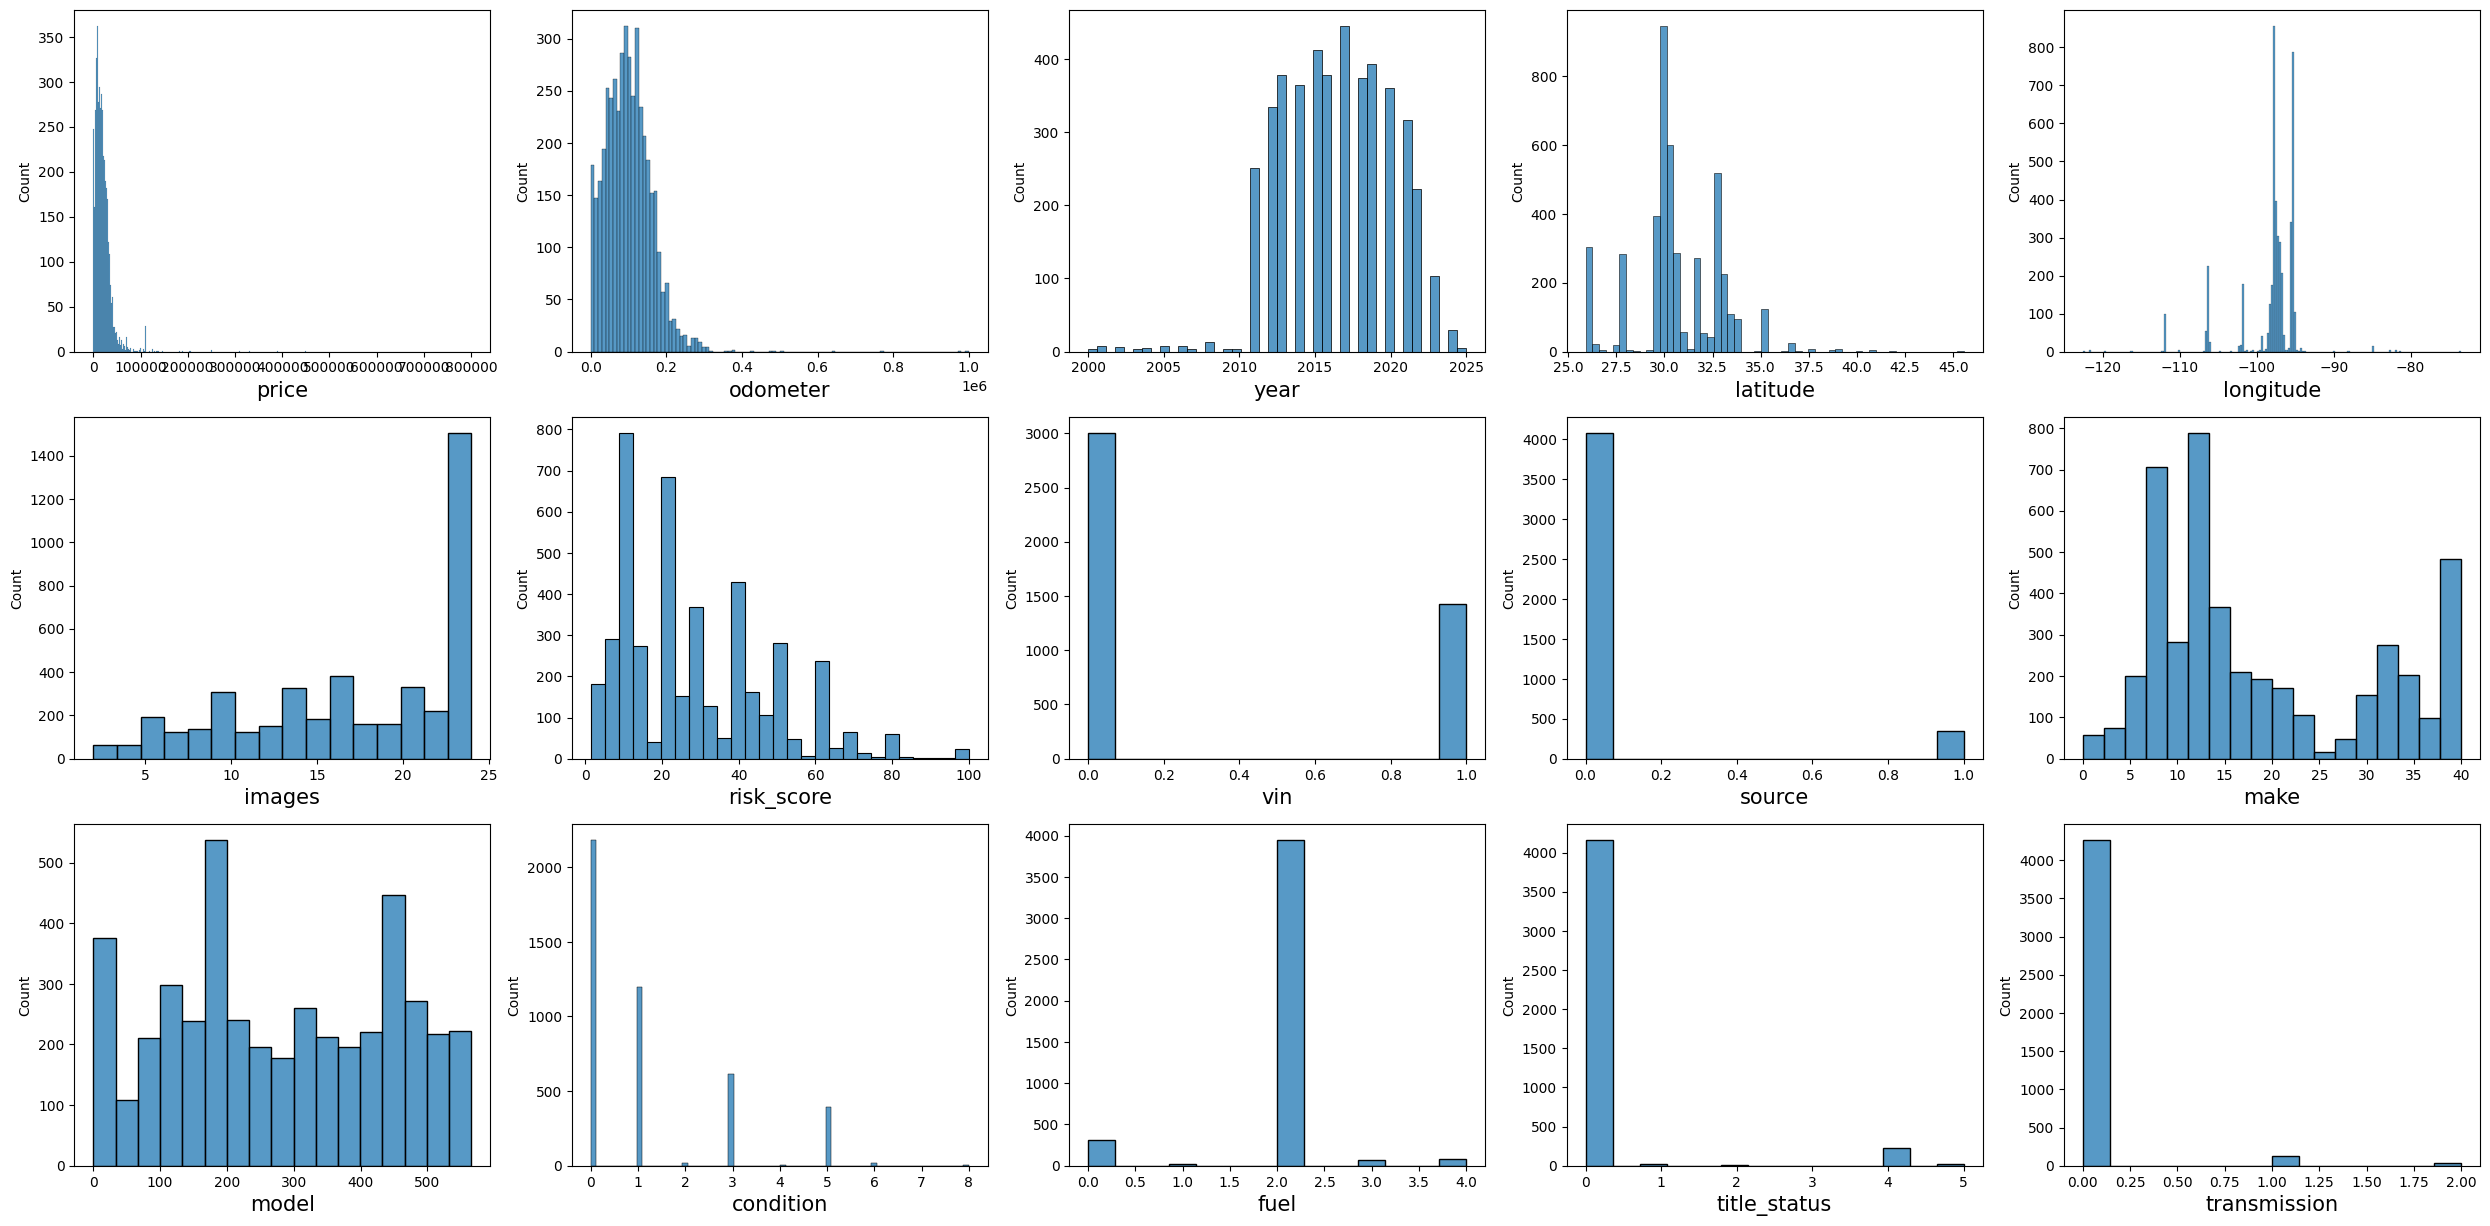

In [77]:
plt.figure(figsize = (25, 20))
plotnumber = 1

for col in numeric_listings.columns:
    ax = plt.subplot(5, 5, plotnumber)
    sns.histplot(numeric_listings[col])
    plt.xlabel(col, fontsize = 15)

    plotnumber += 1

plt.tight_layout()
plt.show()

### Outlier Detection

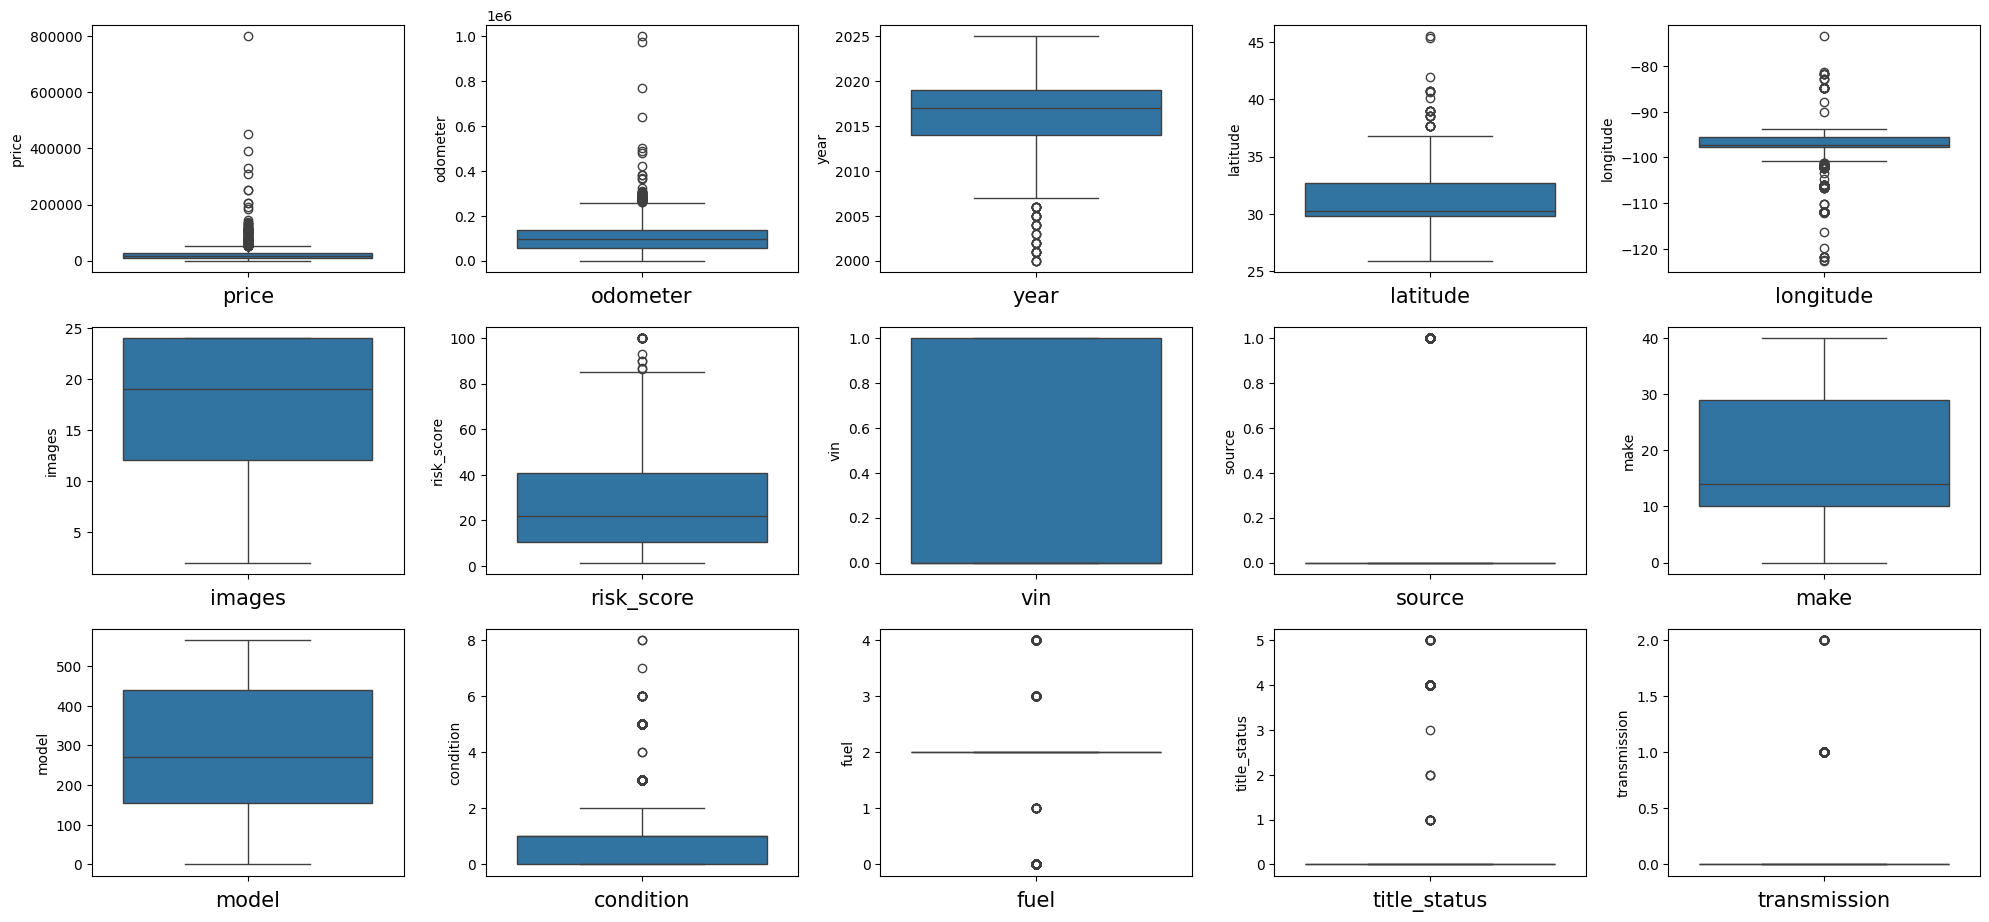

In [78]:
plt.figure(figsize = (20, 15))
plotnumber = 1

for col in numeric_listings.columns:
    if plotnumber <= 24:
        ax = plt.subplot(5, 5, plotnumber)
        sns.boxplot(numeric_listings[col])
        plt.xlabel(col, fontsize = 15)
    
    plotnumber += 1
plt.tight_layout()
plt.show()

In [79]:
cols_to_scale = numeric_listings[["price", "odometer", "year", "latitude", "longitude"]]

scaler = StandardScaler()
scaled_data = scaler.fit_transform(cols_to_scale)

In [80]:
scaled_cols = pd.DataFrame(data = scaled_data, columns = cols_to_scale.columns, index = cols_to_scale.index)
scaled_cols.head()

,price,odometer,year,latitude,longitude
0,-0.619485,0.438304,-1.512667,-1.994320,-0.020919
1,-0.221537,-1.123430,0.966982,-1.982648,-0.018273
2,-0.577554,-0.152223,-0.686117,-1.982648,-0.018273
3,-0.221537,-0.438808,0.415949,-1.982648,-0.018273
4,3.804521,0.167973,0.966982,-1.971573,-0.049500


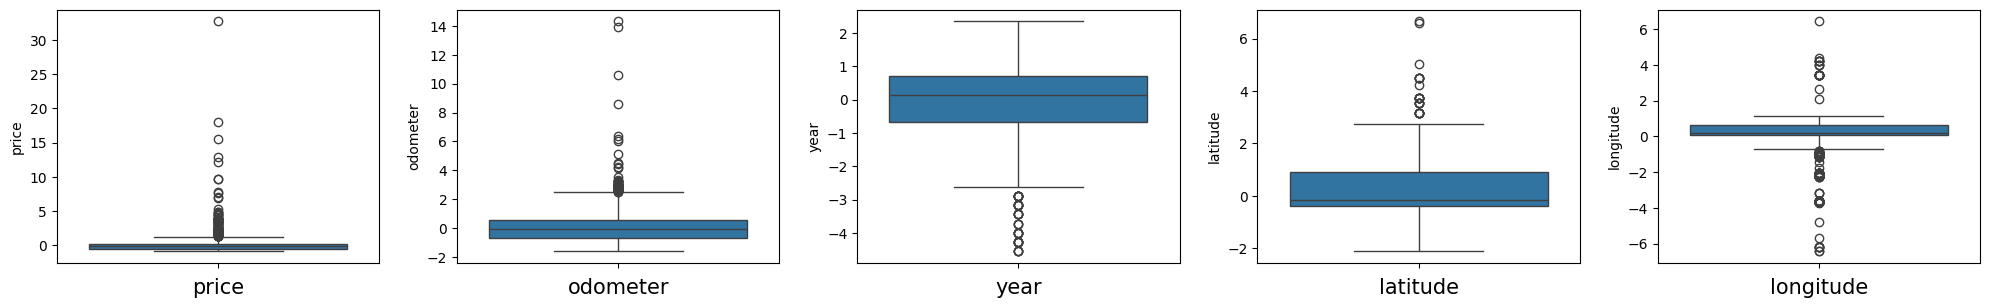

In [81]:
plt.figure(figsize = (20, 15))
plotnumber = 1

for col in scaled_cols.columns:
    if plotnumber <= 24:
        ax = plt.subplot(5, 5, plotnumber)
        sns.boxplot(scaled_cols[col])
        plt.xlabel(col, fontsize = 15)
    
    plotnumber += 1
plt.tight_layout()
plt.show()

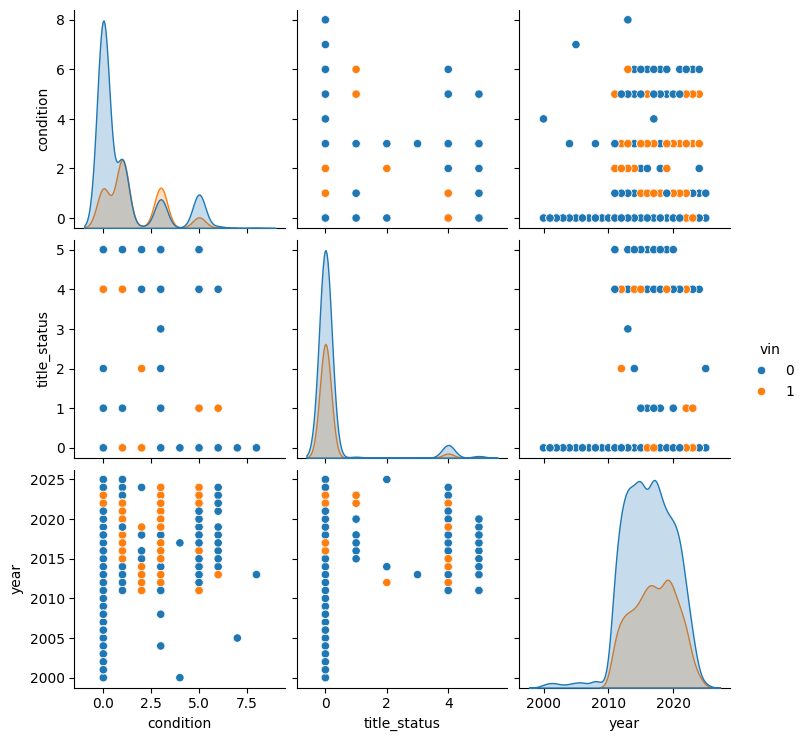

In [82]:
sns.pairplot(numeric_listings, vars = ["condition", "title_status", "year"], hue="vin")